In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import astropy
import scipy
import pyCloudy as pc
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from scipy.interpolate import interp1d
from pyCloudy.utils.astro import conv_arc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

pgf_with_latex = {
    "pgf.texsystem": "xelatex",         # use Xelatex which is TTF font aware
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",             # use serif rather than sans-serif
    "font.serif": "Ubuntu",             # use 'Ubuntu' as the standard font
    "font.sans-serif": [],
    "font.monospace": "Ubuntu Mono",    # use Ubuntu mono if we have mono
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "pgf.rcfonts": False,               # Use pgf.preamble, ignore standard Matplotlib RC
    "text.latex.unicode": True,
    "pgf.preamble": [
        r'\usepackage{fontspec}',
        r'\setmainfont{Ubuntu}',
        r'\setmonofont{Ubuntu Mono}',
        r'\usepackage{unicode-math}'
        r'\setmathfont{Ubuntu}',
        r'\usepackage{cmbright}',
        r'\usepackage{newtxtext,newtxmath}',
        r'\usepackage{wasysym}'
    ]
}

matplotlib.rcParams.update(pgf_with_latex)

dist = 1.65
home_dir = os.environ['HOME'] + '/'
pc.config.cloudy_exe = home_dir + 'c17.02/source/cloudy.exe'


def make_model(dir_, model_name, dens, met):
    full_model_name = '{0}_{1}_{2}'.format(model_name, dens, met)
#    model_name = 'model_4'
#    full_model_name = '{0}{1}'.format(dir__, model_name)
#    dens = 1.653 #log cm-3 значение 2 изначально
#dl = 1.2
    Teff = 30200. #K
    lumi = 69000.
    r_min = 6.05e16 #cm значение 6e11 изначально
#r_max = 5.270e18
    dist = 1.65
    options = ('no molecules', 'COSMIC RAY BACKGROUND',)
    emis_tab = ['H  1  4861.33A', #h beta
            'H  1  6562.81A', #h alpha
            'N  2  6583.45A', #
            'S  2  6716.44A', #
            'S  2  6730.82A'] #
#    abund = {'He' : -0.92, 'C' : 6.85 - 12, 'N' : -4.0, 'O' : -3.40, 'Ne' : -4.00, 
#         'S' : -5.35, 'Ar' : -5.80, 'Fe' : -7.4, 'Cl' : -7.00}
    c_input = pc.CloudyInput('{0}{1}'.format(dir_, full_model_name))
    c_input.set_BB(Teff = Teff, lumi_unit = 'luminosity linear solar', lumi_value = lumi)
    c_input.set_cste_density(dens)
    c_input.set_other('abundances "solar_GASS10.abn" no grains')
    c_input.set_other('metals '+met)#0.57')
#    c_input.set_other('hden 9, power =-2') #в общем чтобы работала не constant плотность, 
#надо разобраться с тем что файл с дефолтно заданным законом dense_fabden.cpp не запускается 
#c_input.import_file('dense_fabden.cpp')
    c_input.set_radius(r_in=np.log10(r_min)) #, r_out=np.log10(r_max))
#    c_input.set_abund(ab_dict = abund, nograins = True)
    c_input.set_other(options)
    c_input.set_iterate() 
    c_input.set_sphere() 
    c_input.set_emis_tab(emis_tab)
    c_input.set_distance(dist=dist, unit='kpc', linear=True)
    c_input.print_input(to_file = True, verbose = False)
    
    
#    arcsec = lambda cm: conv_arc(dist=dist, dist_proj=cm)
dir_ = '/home/mdemyanenko/CLOUDY/'
pc.print_make_file(dir_ = dir_)
pc.log_.level = 2
model_name = 'model_metallicity'
tab_dens = [1.5, 1.65, 1.7, 1.8, 1.9, 2.0, 2.1]
tab_met = ['0.3', '0.4', '0.57','0.65','0.75', '0.9', '1.2']#['0.4','0.425', '0.45', '0.475', '0.5', '0.525', '0.55', '0.575', '0.6'] #, '0.65', '0.7', '0.75', '0.8', '0.85', '0.9', '1.0', '1.05', '1.1', '1.15', '1.2', '1.25']


for met in tab_met:
    for dens in tab_dens:
        make_model(dir_, model_name, dens, met)


n_proc = 32
pc.run_cloudy(dir_ = dir_, n_proc = n_proc, model_name = model_name, use_make = True)
Ms = pc.load_models('{0}{1}'.format(dir_, model_name), verbose = True, read_grains = False)



#for M in Ms:
#    M.print_stats()
#cube_size = 64
#M_sphere = pc.C3D(M, dims=cube_size, center=True, n_dim=1)
#M_spheres = [pc.C3D(M, dims=cube_size, center=True, n_dim=1) for M in Ms]
#    M_spheres.append(M_sphere)


arcsec = lambda cm: conv_arc(dist=dist, dist_proj=cm)


def flux_on_z(M_sphere, line):
    
    a = ((M_sphere.get_emis(line) * M_sphere.cub_coord.delta_x).sum(0))
    b = a / (4 * np.pi)
    
    return b * (np.pi/(180*3600))**2


def r_observe(filename, ra0, dec0): #arcsec

    hdulist = fits.open(filename) 
    f_o = hdulist[0].data
    wcs_hst = WCS(hdulist[0].header) 
    X, Y = np.meshgrid(np.arange(0, f_o.shape[0]), np.arange(0, f_o.shape[1]))
    ra, dec = wcs_hst.wcs_pix2world(X, Y, 0)
    r = np.sqrt(((ra-ra0)*np.cos(dec*np.pi/180))**2 + (dec-dec0)**2)
    
    return r*3600


def flux_observe(filename):
    
    hdulist = fits.open(filename)
    f_o = hdulist[0].data
    
    return f_o


def flux_err_observe(filename_err):
    
    hdulist_err = fits.open(filename_err)
    sigma = hdulist_err[0].data
    
    return sigma


def f_cloudy_interp(line, output_sphere_model, filename, ra0, dec0):
    
    arcsec = lambda cm: conv_arc(dist=dist, dist_proj=cm)
    x_arc = abs(arcsec(output_sphere_model.cub_coord.x_vec))
    f = flux_on_z(output_sphere_model, line)[:,31]
    f_1 = interp1d(x_arc, f, kind = 'linear', bounds_error = False, fill_value = 0)
    ff = f_1(r_observe(filename, ra0, dec0))
    
    return ff


def snr(filename, filename_err, ra0, dec0):
    sn = flux_observe(filename)/flux_err_observe(filename_err)
    mask = (sn > 4)&(sn < 50)&(flux_observe(filename) > 8e-17)&(flux_err_observe(filename_err) > 8e-16)
    
    
    for i in range(0, 64):
        for j in range(0, 64):
            if (mask[i][j] == True)&(r_observe(filename, ra0, dec0)[i][j] > 20):
                sn[i][j] = sn[i][j]
            else:
                sn[i][j] = 0            
    return sn


def mask__snr_for_array(dimenshions, array, min_snr, max_snr, filename, filename_err, ra0, dec0):
    sn = flux_observe(filename)/flux_err_observe(filename_err)
    mask = (sn > min_snr)&(sn < max_snr)&(flux_observe(filename) > 8e-16)&(flux_err_observe(filename_err) > 8e-16)
    
    
    for i in range(0, dimenshions):
        for j in range(0, dimenshions):
            if (mask[i][j] == True)&(r_observe(filename, ra0, dec0)[i][j] > 20):
                array[i][j] = array[i][j]
            else:
                array[i][j] = 0            
    return array


def hihi_line_mask(output_sphere_model, line, filename, filename_err, ra0, dec0):
    hdulist = fits.open(filename) 
    hdulist_err = fits.open(filename_err)
    f_o = hdulist[0].data
    wcs_hst = WCS(hdulist[0].header) 
    sigma = hdulist_err[0].data
    X, Y = np.meshgrid(np.arange(0, f_o.shape[0]), np.arange(0, f_o.shape[1]))
    ra, dec = wcs_hst.wcs_pix2world(X, Y, 0)
    r = np.sqrt(((ra-ra0)*np.cos(dec*np.pi/180))**2 + (dec-dec0)**2)
    arcsec = lambda cm: conv_arc(dist=dist, dist_proj=cm)
    x_arc = abs(arcsec(output_sphere_model.cub_coord.x_vec))
    f = flux_on_z(output_sphere_model, line)[31, :]
    r_new = 3600 * r
    f_1 = interp1d(x_arc, f, kind = 'linear', bounds_error = False, fill_value = 0)
    ff = f_1(r_new)
    hii = (ff - f_o)**2 / ((sigma**2)*(r_new))
    result = mask__snr_for_array(64, hii, 4, 50, filename, filename_err, ra0, dec0)
    
    return result


def hihi_sum_mask(output_sphere_model):
    a_1 = hihi_line_mask(output_sphere_model, 'S__2_671644A',
         '/home/mdemyanenko/CLOUDY/S235_mangal/S235_6717net0_ergs_dereddened.fits',
         '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_6717_ergs_dereddened.fits',
         85.24766667, +35.84625000)
    a_2 = hihi_line_mask(output_sphere_model, 'S__2_673082A',
        '/home/mdemyanenko/CLOUDY/S235_mangal/S235_6731net0_ergs_dereddened.fits',
        '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_6731_ergs_dereddened.fits',
        85.24766667, +35.84625000)
    a_3 = hihi_line_mask(output_sphere_model, 'H__1_486133A', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235_Hb_23toHa_ergs_dereddened.fits', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_Hb_23_ergs_dereddened.fits',
        85.24766667, +35.84625000)
    a_4 = hihi_line_mask(output_sphere_model, 'H__1_656281A', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235_Hanet0_ergs_dereddened.fits', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_Ha_ergs_dereddened.fits',
        85.24766667, +35.84625000)
    a_5 = hihi_line_mask(output_sphere_model, 'N__2_658345A', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235scan_6583_1x1_ergs_dereddened.fits', 
       '/home/mdemyanenko/CLOUDY/S235_mangal/S235_err_NII_1x1_ergs_dereddened.fits',
        85.24766667, +35.84625000)

    hihi_sum = a_1+a_2+a_3+a_4+a_5

    return hihi_sum


def sum_hihi_sum_mask(output_sphere_model):
    chi_sum = np.nansum(hihi_sum_mask(output_sphere_model))
    return chi_sum



/usr/lib64/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in greater
/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in less
/usr/lib64/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib64/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib64/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib64/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.g

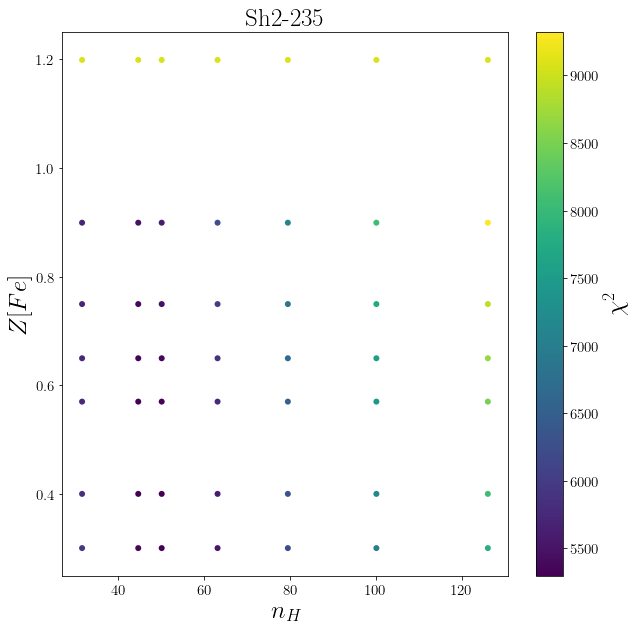

In [2]:
cube_size = 64


g = [sum_hihi_sum_mask(pc.C3D(M, dims=cube_size, center=True, n_dim=1)) for M in Ms]
k = [M.nH_mean for M in Ms]
h = [10**(M.abund['Fe']+4.5) for M in Ms]
plt.figure(figsize=(10,10))
plt.scatter(k, h, c=g, edgecolors = 'none')
plt.xlabel(r'$n_{H}$', size = 25)
plt.ylabel(r'$Z[Fe]$', size = 25)
cb = plt.colorbar()
cb.set_label(r'$\chi^{2}$', size = 25)
plt.title('Sh2-235', size =25);